In [810]:
from typing import Tuple, Dict, Set, List
import random
import unicodedata
import matplotlib.pyplot as plt
import numpy as np
import pickle
from collections import deque
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import tensorflow as tf
import pandas as pd
import joblib
import math, time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


# Safe Grid World (Task 1) 

In [813]:
GRID={}
GRID_SIZE = 10
START = (0, 0)
GOAL = (9, 9)
HAZARDS = {
    (0, 3), (1, 1), (1, 7), (2, 4), (2, 8), (3, 2), (3, 6),
    (4, 5), (5, 3), (5, 8), (6, 1), (6, 6), (7, 4), (8, 2), (8, 7)
}
# 0=UP, 1=DOWN, 2=LEFT, 3=RIGHT
ACTIONS = [0, 1, 2, 3]
ACTION_DELTAS = {
    0: (-1, 0),  # UP
    1: ( 1, 0),  # DOWN
    2: ( 0,-1),  # LEFT
    3: ( 0, 1),  # RIGHT
}


def bounds(r, c):
    return 0 <= r < GRID_SIZE and 0 <= c < GRID_SIZE

def issafe(cell):
    return cell not in HAZARDS and cell != GOAL

def safe_cells():
    cells = []
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            if issafe((r,c)):
                cells.append((r, c))
    return cells
            
def all_states():
    return [(r, c) for r in range(GRID_SIZE) for c in range(GRID_SIZE)]

def nextcheck(s, a):
    r, c = s
    dr, dc = ACTION_DELTAS[a]
    nr, nc = r + dr, c + dc
    if not bounds(nr, nc):
        return (r, c)
    return (nr, nc)

#penalty -0.1 default,Initialise
def init_env(step_penalty: float = -0.1):
    GRID.clear()
    GRID["grid_size"] = GRID_SIZE
    GRID["start"] = START
    GRID["goal"] = GOAL
    GRID["pos"] = START
    GRID["hazards"] = set(HAZARDS)
    GRID["step_penalty"] = step_penalty
    GRID["done"] = False

#reset(fix or random)
def reset(random_start=False):
    if random_start:
        GRID["pos"] = random.choice(safe_cells())
    else:
        GRID["pos"] = GRID["start"]
    GRID["done"] = False
    return GRID["pos"]

def step(action):
    next_pos = nextcheck(GRID["pos"], action)


    # Hazard
    if next_pos in GRID["hazards"]:
        GRID["pos"] = next_pos
        GRID["done"] = True
        return next_pos, -10.0, True

    # Goal
    if next_pos == GRID["goal"]:
        GRID["pos"] = next_pos
        GRID["done"] = True
        return next_pos, 10.0, True

    # Normal step
    GRID["pos"] = next_pos
    return next_pos, GRID["step_penalty"], False



def render():
    grid = np.zeros((GRID_SIZE, GRID_SIZE))
    for (r, c) in HAZARDS:
        grid[r, c] = 1  # hazards
    grid[START] = 2     # start
    grid[GOAL] = 3      # goal
    r, c = GRID.get("pos", START)
    grid[r, c] = 4       # agent position

    cmap = plt.cm.colors.ListedColormap(["lightgrey", "red", "blue", "green", "black"])
    plt.figure(figsize=(5, 5))
    plt.imshow(grid, cmap=cmap, origin='upper')

    # draw grid lines
    plt.xticks(np.arange(-.5, GRID_SIZE, 1), [])
    plt.yticks(np.arange(-.5, GRID_SIZE, 1), [])
    plt.grid(color='white', linewidth=1)
    sr, sc = START
    gr, gc = GOAL
    plt.text(sc, sr, "S", ha="center", va="center",
             color="white", fontsize=18, fontweight="bold")
    plt.text(gc, gr, "G", ha="center", va="center",
             color="white", fontsize=18, fontweight="bold")
    plt.show()




## Fixed Start Mode

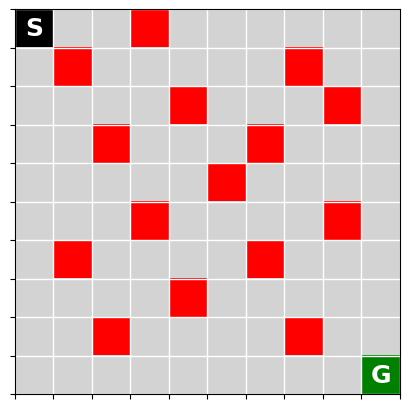

In [816]:
init_env()
reset(random_start=False)
render()

#3,3,1,1,3,1,1,3,1,1,3,1,3,3,3,3,1,1
# for a in [3,3,1,1,3,1,1,3,1,1,3,1,3,3,3,3,1,1]: 
#     ns, r, d = step(a)
#     print(f"Direction:{action_names(a)}, Position:{ns}, Reward:{r}, Done:{d}")
#     render()
#     if d:
#         break


## Random Start Mode

Direction:UP, Position:(2, 4), Reward:-10.0, Done:True


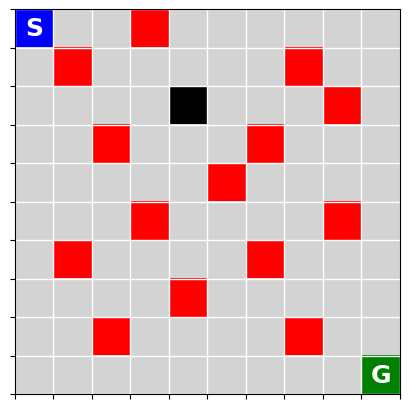

In [819]:
init_env() 
start = reset(random_start=True) 
# render()
for a in [0]: 
    ns, r, d = step(a)
    print(f"Direction:{action_names(a)}, Position:{ns}, Reward:{r}, Done:{d}")
    render()
    if d: break

# Q-Learning Baseline Agent (Task 2)

In [822]:
#baseline            
L_rate = 0.1          
Discount = 0.99          
Eps_start = 1.0      
Eps_min = 0.01       
Eps_decay = 0.995  
Episodes = 2000 
Max_step = 200 

Penalities = [-1.0, -0.1]

#0-99
def number(sets):
    row, column = sets
    return row * GRID_SIZE + column

def action_names(a):
    return {0: "UP", 1: "DOWN", 2: "LEFT", 3: "RIGHT"}[a]

def train_Q_learning(
    step_penalty=-0.1,
    episodes=Episodes,
    max_steps=Max_step,
    alpha=L_rate,
    gamma=Discount,
    eps_start=Eps_start,
    eps_min=Eps_min,
    eps_decay=Eps_decay,
    random_start=False, 
):
    rewards=[]
    lengths = []
    success_rate=[]
    hazard_violations = [] 
    #init
    init_env(step_penalty=step_penalty)
    n_states = GRID_SIZE * GRID_SIZE
    n_actions = 4
    Q = np.zeros((n_states, n_actions), dtype=float)
    eps = eps_start
    t0 = time.time()

    for ep in range(episodes):
        # fix,random_start=False
        s = reset(random_start)
        total_reward, steps, violated = 0.0, 0, 0

        for t in range(max_steps):
            sid = number(s)

            # ε-greedy
            if np.random.rand() < eps:
                a = np.random.randint(n_actions)
            else:
                a = int(np.argmax(Q[sid]))

            s_next, r, done = step(a)
            sid_next = number(s_next)

            # Q-learning ： Q(s,a) ← Q(s,a) + α [ r + γ max_a' Q(s',a') − Q(s,a) ]
            Q[sid, a] += alpha * (r + gamma * np.max(Q[sid_next]) - Q[sid, a])

            total_reward += r
            steps += 1

            # hazard
            if done and r == -10.0:
                violated = 1
            if done:
                break

            s = s_next

        rewards.append(total_reward)
        lengths.append(steps)
        success_rate.append(1 if total_reward > 0 else 0)  # success if reward>0
        hazard_violations.append(violated)

        # each episode ε decay
        eps = max(eps_min, eps * eps_decay)
    total_time = time.time() - t0

    #M 25%
    M = int(math.floor(0.25 * episodes))
    start_idx = episodes - M

    success_rates = 100.0 * (np.sum(np.array(success_rate[start_idx:]) == 1) / M)
    avg_reward   = float(np.mean(rewards[start_idx:]))
    avg_len      = float(np.mean(lengths[start_idx:]))
    total_viol   = int(np.sum(hazard_violations)) 
    train_speed  = episodes / total_time if total_time > 0 else float('inf')

    metrics = {
        "episodes": episodes,
        "M_last": M,
        "success_rate_last25%": success_rates,
        "avg_reward_last25%": avg_reward,
        "avg_len_last25%": avg_len,
        "total_violations": total_viol,
        "training_speed_eps_per_sec": train_speed,
        "step_penalty": step_penalty,
        "alpha": alpha, "gamma": gamma,
        "eps_start": eps_start, "eps_min": eps_min, "eps_decay": eps_decay,
        "random_start": random_start,
        "total_time_sec": total_time,
    }

    label = {
        "rewards": rewards,
        "lengths": lengths,
        "success_rates": success_rate,
        "violations": hazard_violations,
    }

    return Q, metrics, label

#diff penality(-0.1,-1)
results = {}
for pen in Penalities:
    Q, metrics, label = train_Q_learning(
        step_penalty=pen,
        episodes=Episodes,
        max_steps=Max_step,
        alpha=L_rate,
        gamma=Discount,
        eps_start=Eps_start,
        eps_min=Eps_min,
        eps_decay=Eps_decay,
        random_start=False,     
    )
    results[pen] = {"Q": Q, "metrics": metrics, "label": label}
    
p1 = results[-1.0]["metrics"]["avg_reward_last25%"]
p2 = results[-0.1]["metrics"]["avg_reward_last25%"]

better_penalty = -1.0 if p1 > p2 else -0.1
best = results[better_penalty]

save_data = {
    "step_penalty": better_penalty,
    "Q": best["Q"],
    "metrics": best["metrics"]
}
with open("best_Q_table.pkl", "wb") as f:
    pickle.dump(save_data, f)


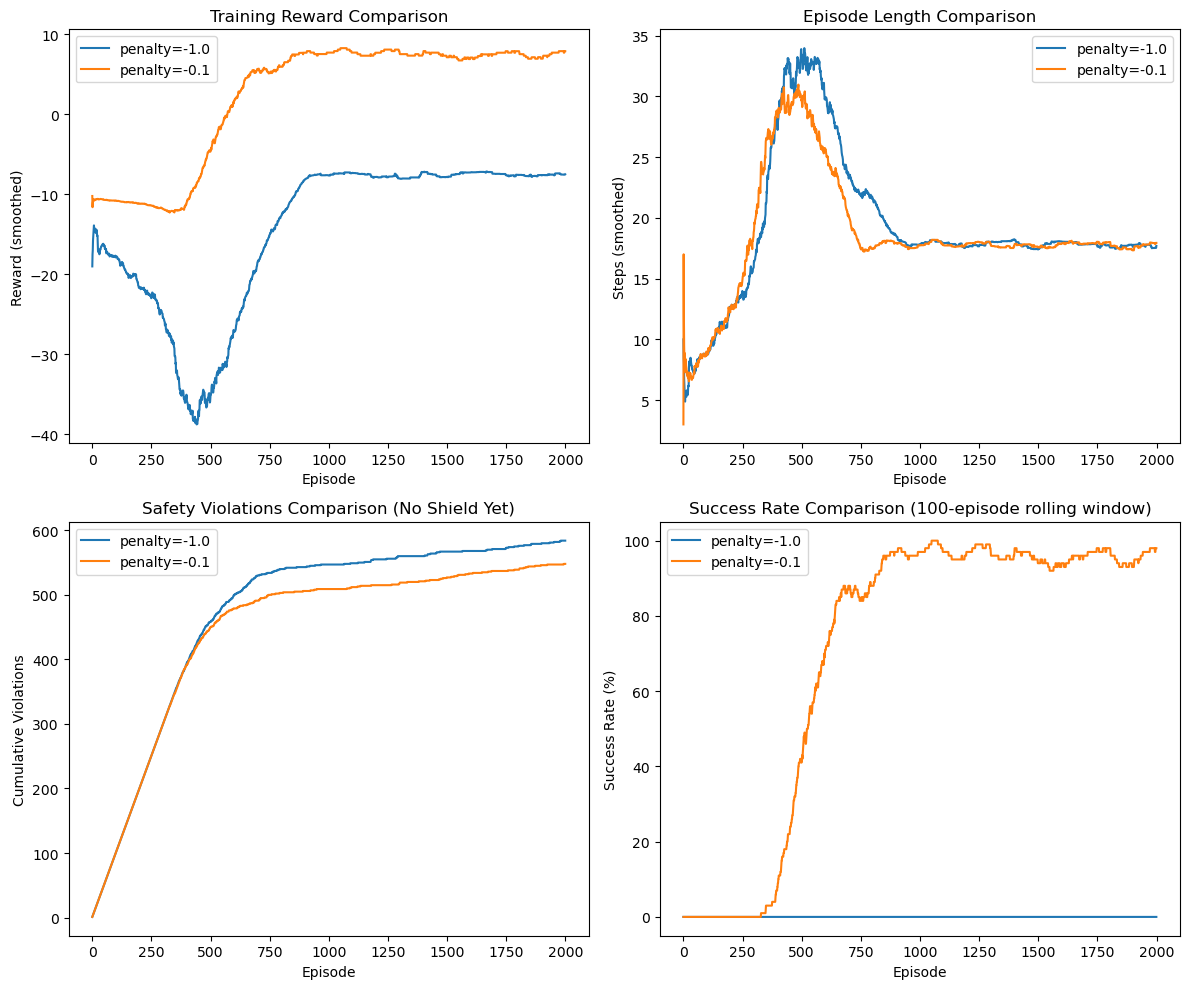

In [823]:
def moving_average(x, window=100):
    x = np.asarray(x, dtype=float)
    if len(x) < window:
        return x.copy()
    c = np.cumsum(np.insert(x, 0, 0))
    ma = (c[window:] - c[:-window]) / float(window)
    head = np.array([np.mean(x[:i+1]) for i in range(window-1)])
    return np.concatenate([head, ma])

def rolling_success_rate(success_rates, window=100):
    return moving_average(np.asarray(success_rates, dtype=float), window) * 100.0

def plot_training_curves(results):
    Penalities = [-1.0, -0.1]  

    #2x2
    fig, axes = plt.subplots(2, 2, figsize=(12, 10)) 

    # reward
    ax = axes[0, 0]
    for pen in Penalities:
        y = moving_average(results[pen]["label"]["rewards"], window=100)
        ax.plot(y, label=f"penalty={pen}")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward (smoothed)")
    ax.set_title("Training Reward Comparison")
    ax.legend()

    # Episode Length
    ax = axes[0, 1]
    for pen in Penalities:
        y = moving_average(results[pen]["label"]["lengths"], window=100)
        ax.plot(y, label=f"penalty={pen}")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Steps (smoothed)")
    ax.set_title("Episode Length Comparison")
    ax.legend()

    # Cumulative Violations
    ax = axes[1, 0]
    for pen in Penalities:
        y = np.cumsum(results[pen]["label"]["violations"])
        ax.plot(y, label=f"penalty={pen}")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Cumulative Violations")
    ax.set_title("Safety Violations Comparison (No Shield Yet)")
    ax.legend()

    # Success Rate (rolling 100)
    ax = axes[1, 1]
    for pen in Penalities:
        y = rolling_success_rate(results[pen]["label"]["success_rates"], window=100)
        ax.plot(y, label=f"penalty={pen}")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Success Rate (%)")
    ax.set_title("Success Rate Comparison (100-episode rolling window)")
    ax.legend()

    plt.tight_layout()
    plt.show()


plot_training_curves(results)


# Complete Dataset Creation (Task 3)

In [826]:
#distance to nearest Hazard s
def distance(s):
    if s in HAZARDS:
        return 0
    minimal=999
    x,y = s
    for x1,y1 in HAZARDS:
        d = abs(x-x1)+abs(y-y1)
        if d<minimal:
            minimal = d
    return minimal

#bfs
def compute_danger_map():
    D = {}
    q = deque()
    for h in HAZARDS:
        D[h] = 0
        q.append(h)

    while q:
        r, c = q.popleft()
        d = D[(r, c)]
        for a in [0, 1, 2, 3]:  
            dr, dc = ACTION_DELTAS[a]
            nr, nc = r + dr, c + dc
            if not bounds(nr, nc):
                continue
            if (nr, nc) not in D:
                D[(nr, nc)] = d + 1
                q.append((nr, nc))

    return D

danger_map = compute_danger_map()
# print(danger_map)

#Risk class
def riskclass(danger_map):
    datasets=[]
    for r in range(GRID_SIZE):
        for c in range(GRID_SIZE):
            s = (r,c)
            if s in HAZARDS or s == GOAL:
                continue 
            for a in [0, 1, 2, 3]:
                s_next = nextcheck(s, a)
                d = danger_map[s_next]
                if d == 0:
                    c = 0
                elif d == 1:
                    c = 1
                elif d == 2:
                    c = 2
                else:
                    c = 3
                datasets.append((s, a, c))

    # 84*4 = 336
    n = len(datasets)
    by_class = Counter([c for _,_,c in datasets])
    print(f"Total datasets: {n}")
    print("Class :", dict(by_class))
    return datasets

samples = riskclass(danger_map)
# print(samples)

Total datasets: 336
Class : {2: 94, 1: 161, 0: 59, 3: 22}


In [829]:
def build_features(samples, danger_map):
    X_list, y_list = [], []
    for s, a, c in samples:
        r, c0 = s
        s_next = nextcheck(s, a)
        r2, c2 = s_next

        # 1-2
        f1 = r / GRID_SIZE
        f2 = c0 / GRID_SIZE

        # 3-6  0=UP, 1=DOWN, 2=LEFT, 3=RIGHT
        a_onehot = [0, 0, 0, 0]
        a_onehot[a] = 1

        # 7-8 
        f7 = r2 / GRID_SIZE
        f8 = c2 / GRID_SIZE

        # 9-10 
        d1  = danger_map[s]
        d2 = danger_map[s_next]
        f9  = d1  / 10.0
        f10 = d2 / 10.0

        X = [f1, f2] + a_onehot + [f7, f8] + [f9, f10]
        X_list.append(X)
        y_list.append(c)

    X = np.asarray(X_list, dtype=np.float32)
    y = np.asarray(y_list, dtype=np.int64)
    return X, y

X, y = build_features(samples, danger_map)
dataset = {
    "X": X,
    "y": y,
    "X_train": X_train, "y_train": y_train,
    "X_val": X_val, "y_val": y_val,
    "X_test": X_test, "y_test": y_test,
}
with open("complete_dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

## Train / Val / Test

In [832]:
random_seed = 42

# 70% train，30% val
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=random_seed, stratify=y
)

# 15% val ，15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=random_seed, stratify=y_temp
)
print("Train size:", len(X_train), "Val size:", len(X_val), "Test size:", len(X_test))



Train size: 235 Val size: 50 Test size: 51


# Safety Shield Training (Task 4)

In [846]:
# Ensure reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()



# Neural network
def build_modelA():
    tf.keras.backend.clear_session()
    neuralmodel = Sequential([
        Input(shape=(10,)),
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(4, activation="softmax"), 
    ])
    neuralmodel.compile(loss="sparse_categorical_crossentropy",metrics=["accuracy"], optimizer=Adam(learning_rate=0.001))
    return neuralmodel
    
es = EarlyStopping(
    monitor="val_loss", mode="min", patience=20, restore_best_weights=True
)

model = build_modelA()
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=0,
)
model.save("safety_shield.keras")

class 0 accuracy: 100.0 %
VAL acc: 1.0
TEST acc: 1.0
TEST Class 0 acc: 1.0
TEST Class 1 acc: 1.0
TEST Class 2 acc: 1.0
TEST Class 3 acc: 1.0


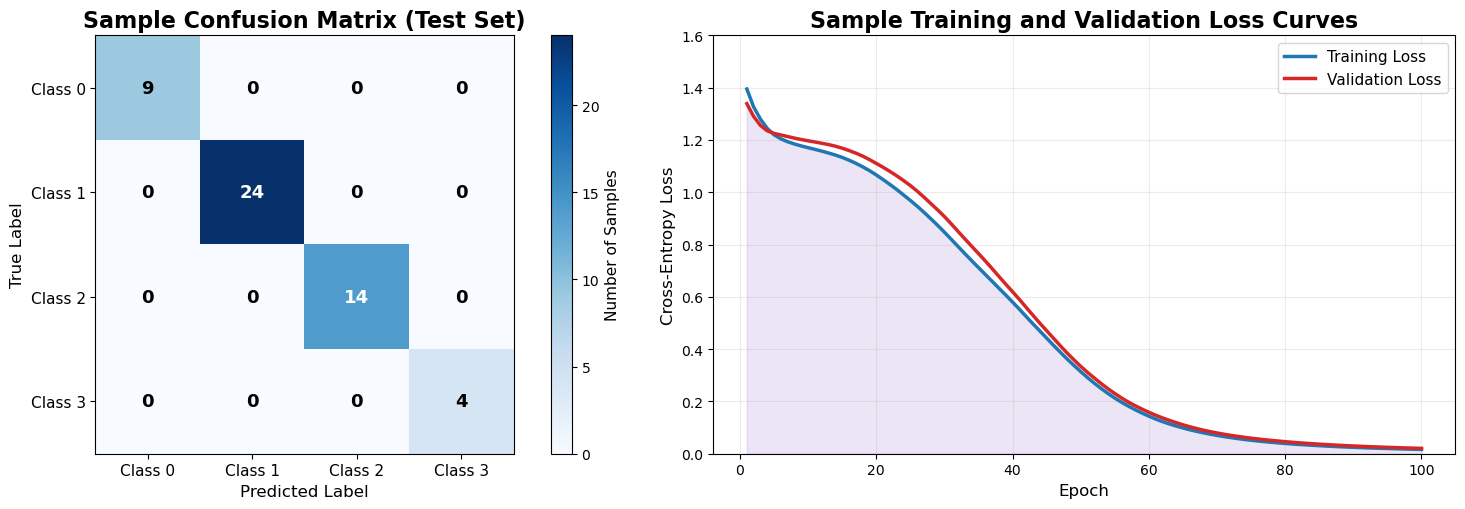

In [836]:
probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(probs, axis=1)

labels = [0, 1, 2, 3] 
cm = confusion_matrix(y_test, y_pred, labels=labels)
print("class 0 accuracy:",(cm[0,0] / sum(cm[0,:]))*100,"%")
print("VAL acc:", accuracy_score(y_val, np.argmax(model.predict(X_val, verbose=0),1)))
print("TEST acc:", accuracy_score(y_test, y_pred))
# per-class acc（
for cls in range(4):
    idx = (y_test==cls)
    print(f"TEST Class {cls} acc:", (y_pred[idx]==cls).mean())
_hist = history if "history" in dir() else hist


FIGSIZE = (16, 5.2)
TITLE_FONT = dict(fontsize=16, fontweight="bold")
AX_LABEL_FONT = dict(fontsize=12)
TICK_LABEL_FONT = dict(fontsize=11)
LINE_WIDTH = 2.5
GRID_ALPHA = 0.25
TRAIN_COLOR = "#1f77b4"
VAL_COLOR   = "#d62728"  
FILL_COLOR  = "#7e57c2"  



fig, axes = plt.subplots(1, 2, figsize=FIGSIZE)

# Confusion Matrix
ax = axes[0]
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Sample Confusion Matrix (Test Set)", **TITLE_FONT)
ax.set_xlabel("Predicted Label", **AX_LABEL_FONT)
ax.set_ylabel("True Label", **AX_LABEL_FONT)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))
ax.set_xticklabels([f"Class {i}" for i in labels], fontdict=TICK_LABEL_FONT)
ax.set_yticklabels([f"Class {i}" for i in labels], fontdict=TICK_LABEL_FONT)
thresh = cm.max() * 0.5 if cm.size else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        val = cm[i, j]
        color = "white" if val > thresh else "black"
        ax.text(j, i, str(val), ha="center", va="center",
                color=color, fontsize=13, fontweight="bold")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Number of Samples", fontsize=11)


#loss
ax2 = axes[1]
train_loss = _hist.history["loss"]
val_loss   = _hist.history["val_loss"]
x = np.arange(1, len(train_loss) + 1)
ax2.plot(x, train_loss, label="Training Loss", color=TRAIN_COLOR, linewidth=LINE_WIDTH)
ax2.plot(x, val_loss,   label="Validation Loss", color=VAL_COLOR,   linewidth=LINE_WIDTH)
base = np.minimum(train_loss, val_loss) 
ax2.fill_between(x, np.minimum(train_loss, val_loss), alpha=0.15, color=FILL_COLOR)

ax2.set_title("Sample Training and Validation Loss Curves", **TITLE_FONT)
ax2.set_xlabel("Epoch", **AX_LABEL_FONT)
ax2.set_ylabel("Cross-Entropy Loss", **AX_LABEL_FONT)
ax2.grid(True, alpha=GRID_ALPHA)
ax2.legend(frameon=True, fontsize=11)
ymax = max(max(train_loss), max(val_loss))
ax2.set_ylim(0, max(1.6, ymax * 1.1))


plt.tight_layout()
plt.show()

#  Safe RL with Multi-Class Shield (Task 5)

In [838]:
random.seed(123); 
np.random.seed(123); 
tf.keras.utils.set_random_seed(123)
# precompute and cache shield predictions (speeds up a lot)
ALL_STATES = [(r, c) for r in range(GRID_SIZE) for c in range(GRID_SIZE)]

next_id = np.empty((GRID_SIZE * GRID_SIZE, 4), dtype=int)
for sid, (r, c) in enumerate(all_states()):
    for a in (0, 1, 2, 3):
        nr, nc = nextcheck((r, c), a)        
        next_id[sid, a] = nr * GRID_SIZE + nc

X_all = np.zeros((GRID_SIZE * GRID_SIZE, 4, 10), dtype=np.float32)
for sid, (r, c) in enumerate(ALL_STATES):
    for a in (0, 1, 2, 3):
        r2, c2 = ALL_STATES[next_id[sid, a]]
        onehot = [0, 0, 0, 0]; onehot[a] = 1
        X_all[sid, a, :] = np.array(
            [r/GRID_SIZE, c/GRID_SIZE] + onehot +
            [r2/GRID_SIZE, c2/GRID_SIZE, danger_map[(r, c)]/10.0, danger_map[(r2, c2)]/10.0],
            dtype=np.float32
        )


probs_all = model.predict(X_all.reshape(-1, 10), verbose=0).reshape(GRID_SIZE * GRID_SIZE, 4, 4)
pred_class_cache = probs_all.argmax(axis=2).astype(np.int16)   # 形状 (100, 4)
p_safe_cache     = probs_all[:, :, 3].astype(np.float32)       # P(class=3)，形状 (100, 4)



#single
def build_feature5(s, a):
    r, c = s
    r2, c2 = nextcheck(s, a)
    f1, f2 = r / GRID_SIZE, c / GRID_SIZE
    onehot = [0, 0, 0, 0]; onehot[a] = 1
    f7, f8 = r2 / GRID_SIZE, c2 / GRID_SIZE
    d_s  = danger_map[s]
    d_sp = danger_map[(r2, c2)]
    f9, f10 = d_s / 10.0, d_sp / 10.0
    return np.array([f1, f2] + onehot + [f7, f8] + [f9, f10], dtype=np.float32)

def Threshold(s, theta=2):
    sid = s[0]*GRID_SIZE + s[1]
    info, acc = {}, []
    for a in (0, 1, 2, 3):
        c = int(pred_class_cache[sid, a])    
        p = probs_all[sid, a]                
        info[a] = (c, p)
        if c > theta:
            acc.append(a)
    return acc, info



def choose_action_with_shield(s, Q, eps, theta=2):
    # ε-greedy
    sid = s[0]*GRID_SIZE + s[1]
    if np.random.rand() < eps:
        a0 = np.random.randint(4)
    else:
        a0 = int(np.argmax(Q[sid]))

    acc, info = Threshold(s, theta=theta)
    intervened = 0
    final_a = a0

    #Intervention
    if a0 not in acc:
        intervened = 1
        if len(acc) > 0:
            #choose max Q 
            qs = [(a, Q[sid, a]) for a in acc]
            final_a = max(qs, key=lambda t: t[1])[0]
        else:
            # choose max class
            ranked = sorted(
                [(a, info[a][0], info[a][1]) for a in [0,1,2,3]],
                key=lambda t: (t[1], t[2][3]),  
                reverse=True
            )
            final_a = ranked[0][0]
    return final_a, intervened


In [839]:
def run_training(with_shield=True, theta=2,
                 episodes=1000, max_steps=200,
                 alpha=0.1, gamma=0.99,
                 eps_start=1.0, eps_min=0.01, eps_decay=0.995):
    # init env
    init_env(step_penalty=better_penalty)

    # copy Q
    Q_run = Q.copy()

    rewards, lengths = [], []
    success_flags, violations = [], []
    interventions = []

    eps = eps_start
    t0 = time.time()

    for ep in range(episodes):
        s = reset(random_start=True)   
        total_r, steps, viol, inter = 0.0, 0, 0, 0

        for t in range(max_steps):
            sid = s[0]*GRID_SIZE + s[1]

            if with_shield:
                a, intervened = choose_action_with_shield(s, Q_run, eps, theta=theta)
                inter += intervened
            else:
                # baseline，ε-greedy on Q
                if np.random.rand() < eps:
                    a = np.random.randint(4)
                else:
                    a = int(np.argmax(Q_run[sid]))

            s_next, r, done = step(a)
            sid_next = s_next[0]*GRID_SIZE + s_next[1]

            # Q-learning update
            Q_run[sid, a] += alpha * (r + gamma * np.max(Q_run[sid_next]) - Q_run[sid, a])

            total_r += r
            steps += 1
            if done and r == -10.0:
                viol += 1
            if done:
                break
            s = s_next

        rewards.append(total_r)
        lengths.append(steps)
        success_flags.append(1 if total_r > 0 else 0)
        violations.append(viol)
        interventions.append(inter if with_shield else 0)

        eps = max(eps_min, eps * eps_decay)

    spent = time.time() - t0
    return {
        "Q": Q_run,
        "logs": {
            "rewards": rewards,
            "lengths": lengths,
            "success_flags": success_flags,
            "violations": violations,        
            "interventions": interventions,  
        },
        "time_sec": spent
    }

# baseline vs shield(θ=2)
res_base = run_training(with_shield=False)
res_shld0 = run_training(with_shield=True, theta=0)
res_shld2 = run_training(with_shield=True, theta=2)
print("Done. time base/shield (s):", res_base["time_sec"], res_shld2["time_sec"])


Done. time base/shield (s): 0.03732609748840332 0.7755069732666016


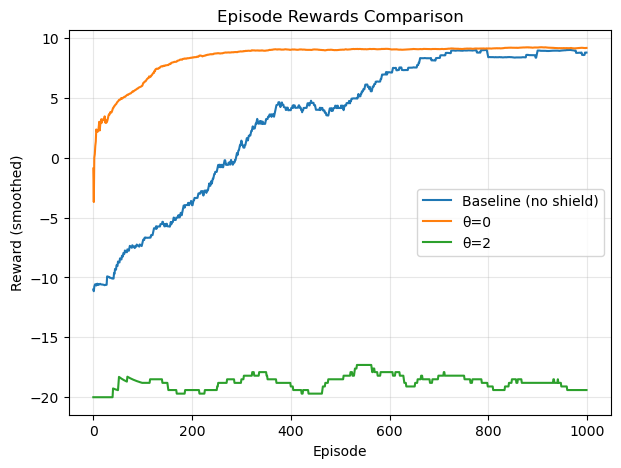

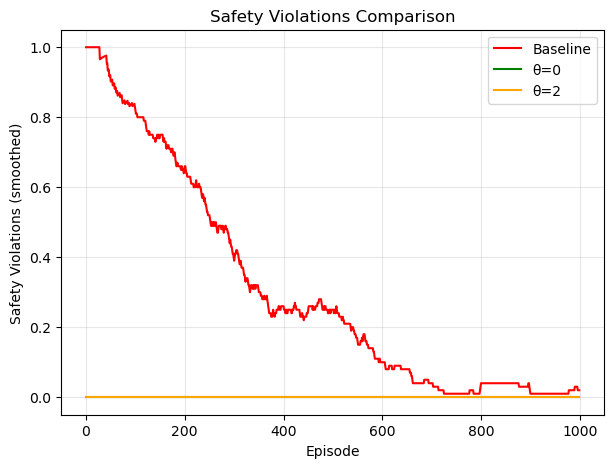

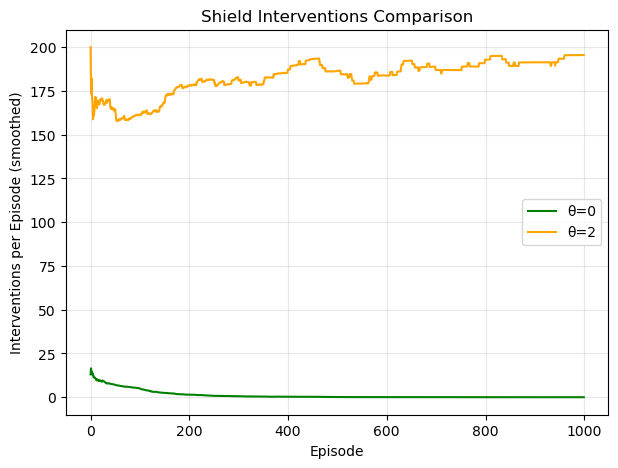

THRESHOLD COMPARISON SUMMARY
Episodes: 1000

SAFETY VIOLATIONS:
  Baseline : 2
  θ=0       : 0
  θ=2       : 0

SUCCESS RATE:
  Baseline : 98.0%
  θ=0       : 100.0%
  θ=2       : 2.0%

INTERVENTIONS (avg per episode):
  Baseline : n/a
  θ=0       : 0.0
  θ=2       : 195.5

FINAL REWARD (last 100 eps avg):
  Baseline : 8.78
  θ=0       : 9.17
  θ=2       : -19.40

KEY INSIGHT:
  θ=0: fewer interventions, balanced safety and performance.
  θ=2: more interventions, maximum safety, slightly lower reward.


In [840]:
plt.figure(figsize=(7,5))
plt.plot(moving_average(res_base["logs"]["rewards"]), label="Baseline (no shield)")
plt.plot(moving_average(res_shld0["logs"]["rewards"]), label="θ=0")
plt.plot(moving_average(res_shld2["logs"]["rewards"]), label="θ=2")
plt.title("Episode Rewards Comparison")
plt.xlabel("Episode")
plt.ylabel("Reward (smoothed)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Violations
plt.figure(figsize=(7,5))
plt.plot(moving_average(res_base["logs"]["violations"]), label="Baseline", color="r")
plt.plot(moving_average(res_shld0["logs"]["violations"]), label="θ=0", color="g")
plt.plot(moving_average(res_shld2["logs"]["violations"]), label="θ=2", color="orange")
plt.title("Safety Violations Comparison")
plt.xlabel("Episode")
plt.ylabel("Safety Violations (smoothed)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Interventions
plt.figure(figsize=(7,5))
plt.plot(moving_average(res_shld0["logs"]["interventions"]), label="θ=0", color="g")
plt.plot(moving_average(res_shld2["logs"]["interventions"]), label="θ=2", color="orange")
plt.title("Shield Interventions Comparison")
plt.xlabel("Episode")
plt.ylabel("Interventions per Episode (smoothed)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

def summarize_last100(res):
    R = np.array(res["logs"]["rewards"])
    S = np.array(res["logs"]["success_flags"])
    V = np.array(res["logs"]["violations"])
    I = np.array(res["logs"]["interventions"])
    sl = slice(-100, None)
    return dict(
        avg_reward=R[sl].mean(),
        success_rate=S[sl].mean()*100,
        violations=V[sl].sum(),
        interventions_avg=I[sl].mean()
    )

sum_base = summarize_last100(res_base)
sum_0 = summarize_last100(res_shld0)
sum_2 = summarize_last100(res_shld2)

print("THRESHOLD COMPARISON SUMMARY")
print("="*60)
print(f"Episodes: {len(res_base['logs']['rewards'])}\n")

print("SAFETY VIOLATIONS:")
print(f"  Baseline : {sum_base['violations']}")
print(f"  θ=0       : {sum_0['violations']}")
print(f"  θ=2       : {sum_2['violations']}\n")

print("SUCCESS RATE:")
print(f"  Baseline : {sum_base['success_rate']:.1f}%")
print(f"  θ=0       : {sum_0['success_rate']:.1f}%")
print(f"  θ=2       : {sum_2['success_rate']:.1f}%\n")

print("INTERVENTIONS (avg per episode):")
print(f"  Baseline : n/a")
print(f"  θ=0       : {sum_0['interventions_avg']:.1f}")
print(f"  θ=2       : {sum_2['interventions_avg']:.1f}\n")

print("FINAL REWARD (last 100 eps avg):")
print(f"  Baseline : {sum_base['avg_reward']:.2f}")
print(f"  θ=0       : {sum_0['avg_reward']:.2f}")
print(f"  θ=2       : {sum_2['avg_reward']:.2f}\n")

print("KEY INSIGHT:")
print("  θ=0: fewer interventions, balanced safety and performance.")
print("  θ=2: more interventions, maximum safety, slightly lower reward.")
